<a id='start'></a>
### Содержание

<a href='#step1'>1. Исследовательский анализ данных</a>

<a href='#step2'>2. Предобработка данных</a>

<a href='#step3'>3. Обучение моделей</a>

<a href='#step4'>3. Тестирование моделей</a>

<a href='#step5'>5. Выводы по работе</a>

<a href='#step6'>6. Отчет</a>

<a id='step1'></a>
# 1. Исследовательский анализ данных

In [76]:
! pip install lofo-importance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from IPython.display import display

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

from catboost import CatBoostRegressor
import lightgbm as lgb

from lofo import FLOFOImportance, Dataset, plot_importance

In [2]:
try:
    arc = pd.read_csv('datasets/data_arc.csv')
    bulk = pd.read_csv('datasets/data_bulk.csv')
    bulk_time = pd.read_csv('datasets/data_bulk_time.csv')
    gas = pd.read_csv('datasets/data_gas.csv')
    temp = pd.read_csv('datasets/data_temp.csv')
    wire = pd.read_csv('datasets/data_wire.csv')
    wire_time = pd.read_csv('datasets/data_wire_time.csv')
except FileNotFoundError:
    arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    bulk = pd.read_csv('/datasets/final_steel/data_arc.csv')
    bulk_time = pd.read_csv('/datasets/final_steel/data_arc.csv')
    gas = pd.read_csv('/datasets/final_steel/data_arc.csv')
    temp = pd.read_csv('/datasets/final_steel/data_arc.csv')
    wire = pd.read_csv('/datasets/final_steel/data_arc.csv')
    wire_time = pd.read_csv('/datasets/final_steel/data_arc.csv')

Преобразуем названия столбцов в датафреймах в удобный вид.

In [3]:
dataframes = [arc, bulk, bulk_time, gas, temp, wire, wire_time]
for d in dataframes:
    d.columns = d.columns.str.lower().str.replace(' ','_')

In [4]:
arc.columns = ['key', 'heat_start', 'heat_end', 'active_power', 'reactive_power']
gas.columns = ['key', 'gas']
temp.columns = ['key', 'measure_time', 'temp']

In [5]:
def df_info(df):
    display(df.head(10))
    display(df.info())
    display(df.describe())
    print('Число пропусков:')
    display(df.isna().sum())

### Данные об электродах

In [6]:
df_info(arc)

,key,heat_start,heat_end,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   heat_start      14876 non-null  object 
 2   heat_end        14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Число пропусков:


key               0
heat_start        0
heat_end          0
active_power      0
reactive_power    0
dtype: int64

In [7]:
print('Число отрицательных значений реактивной мощности:',arc[arc['reactive_power']<0]['key'].count())

Число отрицательных значений реактивной мощности: 1


Дата и время в датафрейме имеют неверный тип.

Оценим количество выбросов в признаках активной и реактивной мощности с помощью диаграммы размаха.

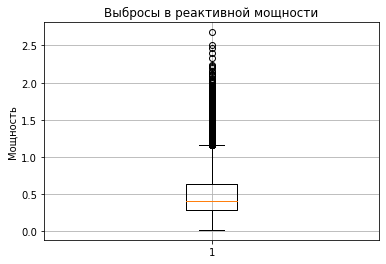

Количество аномалий:  599


In [8]:
boxplot = plt.boxplot(arc[arc['reactive_power']>=0]['reactive_power'].values)
plt.ylabel('Мощность')
plt.title('Выбросы в реактивной мощности')
plt.grid(True)
plt.show()
outliers = list(boxplot['fliers'][0].get_data()[1])
arc_outliers = arc[arc['reactive_power'].isin(outliers)] 
print("Количество аномалий: ", len(arc_outliers))

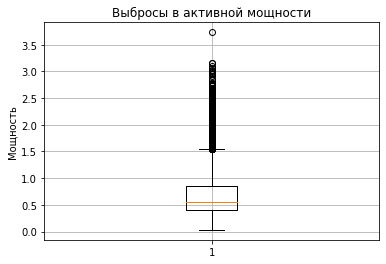

Количество аномалий:  569


In [9]:
boxplot = plt.boxplot(arc['active_power'].values)
plt.ylabel('Мощность')
plt.title('Выбросы в активной мощности')
plt.grid(True)
plt.show()
outliers = list(boxplot['fliers'][0].get_data()[1])
arc_outliers = arc[arc['active_power'].isin(outliers)] 
print("Количество аномалий: ", len(arc_outliers))

### Данные о проволоке

In [10]:
df_info(wire_time)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Число пропусков:


key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

Дата и время в датафрейме имеют неверный тип данных.

In [11]:
df_info(wire)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Число пропусков:


key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

В датафрейме наблюдается большое количество пропусков. Будем считать, что если информации нет, то тот или иной тип проволоки не добавлялся, а значит можно будет заменить пропуски на 0.

Оценим наличие выбросов.

Text(0.5, 1.0, 'Диаграммы размахов признаков датафрейма wire')

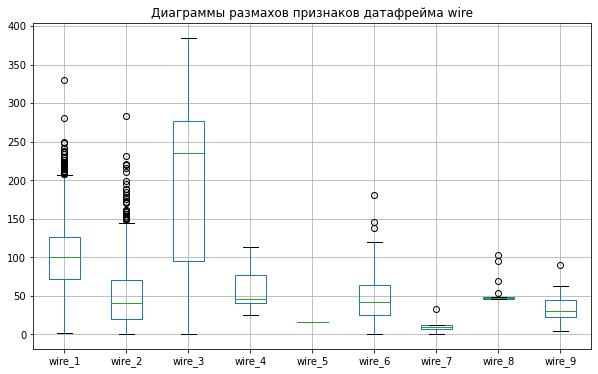

In [12]:
boxplot = wire.boxplot(['wire_1','wire_2','wire_3','wire_4','wire_5','wire_6','wire_7','wire_8','wire_9'], figsize=(10,6))
plt.title('Диаграммы размахов признаков датафрейма wire')

В ряде признаком (_wire_1_,_wire_2_) наблюдается значительное количество выбросов.

### Температура

In [13]:
df_info(temp)

,key,measure_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   measure_time  15907 non-null  object 
 2   temp          13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,temp
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Число пропусков:


key                0
measure_time       0
temp            2901
dtype: int64

Проверим количество партий с одним измерением.

In [14]:
measure_count = temp.groupby('key')['measure_time'].count()
print('Партий с одним измерением:',measure_count[measure_count == 1].count())

Партий с одним измерением: 2


Имеются пропуски в столбце температур, потребуется удаление записей партий с одним измерением температуры для корректного создания общего датасета.

### Газ

In [15]:
df_info(gas)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Число пропусков:


key    0
gas    0
dtype: int64

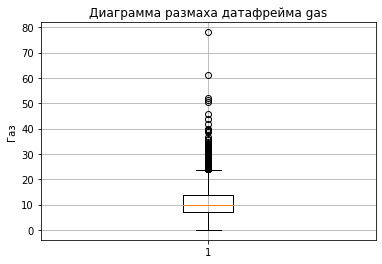

Количество аномалий:  126


In [16]:
boxplot = plt.boxplot(gas['gas'].values)
plt.ylabel('Газ')
plt.title('Диаграмма размаха датафрейма gas')
plt.grid(True)
plt.show()
outliers = list(boxplot['fliers'][0].get_data()[1])
gas_outliers = gas[gas['gas'].isin(outliers)] 
print("Количество аномалий: ", len(gas_outliers))

### Сыпучие добавки

In [17]:
df_info(bulk_time)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Число пропусков:


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

Дата и время имеют неверный тип.

In [18]:
df_info(bulk)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Число пропусков:


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

Text(0.5, 1.0, 'Диаграммы размахов признаков датафрейма bulk')

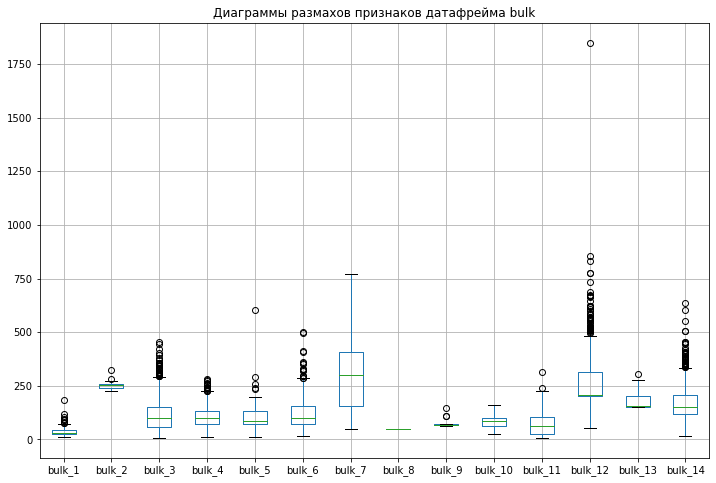

In [19]:
boxplot = bulk.boxplot(['bulk_1','bulk_2','bulk_3','bulk_4','bulk_5','bulk_6','bulk_7','bulk_8','bulk_9','bulk_10','bulk_11','bulk_12','bulk_13','bulk_14'], figsize=(12,8))
plt.title('Диаграммы размахов признаков датафрейма bulk')

Наблюдаются признаки с небольшим количеством записей (меньше 100 при общем количестве строк в 3129).
 
Поскольку тут содержится информация об объеме сыпучих добавок, пропуски заменим на 0 (то есть добавка не засыпалась).

По диаграммам размаха заметно наличие большого количества выбросов в ряде признаков (_bulk_1, bulk_3, bulk_4, bulk_12, bulk_14_).

## Выводы по исследованию

В ходе исследования данных были выявлены следующие особенности датасета: <br>
1. датасет разбит на части; <br>
2. наличие большого числа пропусков, подлежащих заполнению или удалению; <br>
3. в ряде датафреймов имеются признаки, содержащие крайне малое количество актуальных записей (менее 10% от объема датафрейма); <br>
4. с помощью диаграммы размаха определены выбросы в ряде признаков; <br>
5. дата и время имеют неверный тип во всех датафреймах.

<a href='#start'>К содержанию</a>

<a id='step2'></a>
# 2. Предобработка данных

## 2.1 Преобразование типов

In [20]:
arc['heat_start'] = pd.to_datetime(arc['heat_start'])
arc['heat_end'] = pd.to_datetime(arc['heat_end'])
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   heat_start      14876 non-null  datetime64[ns]
 2   heat_end        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [21]:
temp['measure_time'] = pd.to_datetime(temp['measure_time'])
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   measure_time  15907 non-null  datetime64[ns]
 2   temp          13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


## 2.2 Обработка пропусков

In [22]:
temp = temp.dropna()
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13006 non-null  int64         
 1   measure_time  13006 non-null  datetime64[ns]
 2   temp          13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


In [23]:
wire = wire.fillna(0)
bulk = bulk.fillna(0)

## 2.3 Обработка аномалий

Заменим отрицательное значение реактивной мощности в `arc` на среднее.

In [24]:
arc['reactive_power'][arc['reactive_power']<0] = np.mean(arc['reactive_power'])

In [25]:
arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.500720
std,934.571502,0.408159,0.310870
min,1.000000,0.030002,0.020806
25%,806.000000,0.395297,0.291008
50%,1617.000000,0.555517,0.416083
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


## 2.4 Подготовка датасета

### Добавление признаков

Каждая партия стали в датасете будет представлена одной строкой.

Признаки, которые будут добавлены к датасету с измерением температуры: количество измерений температуры для партии, начальная температура, конечная температура.

Одновременно с этим оставим в датасете только те партии, в которых больше 1 измерения.

In [26]:
measure_count = temp.groupby('key')['measure_time'].count()
print('Партий с одним измерением:',measure_count[measure_count == 1].count())

Партий с одним измерением: 741


In [27]:
temp_with_features = temp.groupby('key').agg(['count', 'first', 'last']).reset_index()
temp_with_features.head()

key measure_time                                          temp          \
             count               first                last count   first   
0   1            5 2019-05-03 11:16:18 2019-05-03 11:30:39     5  1571.0   
1   2            6 2019-05-03 11:37:27 2019-05-03 11:59:12     6  1581.0   
2   3            5 2019-05-03 12:13:17 2019-05-03 12:34:57     5  1596.0   
3   4            3 2019-05-03 12:52:57 2019-05-03 12:59:25     3  1601.0   
4   5            2 2019-05-03 13:23:19 2019-05-03 13:36:01     2  1576.0   

           
     last  
0  1613.0  
1  1602.0  
2  1599.0  
3  1625.0  
4  1602.0

In [28]:
temp_with_features.columns = ['key', 'measure_count', 'first_measure_time', 'last_measure_time','temp_count', 'first_measure','last_measure']
temp_with_features = temp_with_features[~temp_with_features['key'].isin(measure_count[measure_count == 1].index)]

In [29]:
temp_with_features['measure_time_diff'] = (temp_with_features['last_measure_time'] - temp_with_features['first_measure_time']).dt.total_seconds()
temp_with_features.drop(['temp_count', 'first_measure_time','last_measure_time'], axis=1, inplace=True)
display(temp_with_features.head())
print('Количество партий в датасете:', temp_with_features['key'].count())

,key,measure_count,first_measure,last_measure,measure_time_diff
0,1,5,1571.0,1613.0,861.0
1,2,6,1581.0,1602.0,1305.0
2,3,5,1596.0,1599.0,1300.0
3,4,3,1601.0,1625.0,388.0
4,5,2,1576.0,1602.0,762.0


Количество партий в датасете: 2475


In [30]:
temp_with_features[temp_with_features['first_measure']==temp_with_features['last_measure']].count()

key                  42
measure_count        42
first_measure        42
last_measure         42
measure_time_diff    42
dtype: int64

Создадим признаки в датафрейме с информацией о нагреве: суммарное время нагрева электронами, среднее соотношение потребления активной и реактивной мощности, количество запусков нагрева электродами.

In [31]:
arc['heat_time'] = (arc['heat_end'] - arc['heat_start']).dt.total_seconds()
arc_with_features = arc.groupby('key').agg(['count', 'sum']).reset_index()
arc_with_features.columns= ['key','1','active_power_sum','2','reactive_power_sum','heat_count','heat_time_sum']
arc_with_features.drop(['1','2'], axis=1, inplace=True)
arc_with_features.head()

,key,active_power_sum,reactive_power_sum,heat_count,heat_time_sum
0,1,4.878147,3.183241,5,1098.0
1,2,3.052598,1.998112,4,811.0
2,3,2.525882,1.599076,5,655.0
3,4,3.209250,2.060298,4,741.0
4,5,3.347173,2.252643,4,869.0


In [32]:
arc_with_features['mean_power_ratio'] = arc_with_features['active_power_sum'] / arc_with_features['reactive_power_sum'] / arc_with_features['heat_count']
arc_with_features.head()
print('Количество партий в датасете:', arc_with_features['key'].count())

Количество партий в датасете: 3214


### Объединение датафреймов

In [33]:
dataset = pd.merge(temp_with_features, arc_with_features, how='inner', on=['key'])
dataset = pd.merge(dataset, bulk, how='inner', on=['key'])
dataset = pd.merge(dataset, wire, how='inner', on=['key'])

In [34]:
dataset.head()

,key,measure_count,first_measure,last_measure,measure_time_diff,active_power_sum,reactive_power_sum,heat_count,heat_time_sum,mean_power_ratio,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,5,1571.0,1613.0,861.0,4.878147,3.183241,5,1098.0,0.306489,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,6,1581.0,1602.0,1305.0,3.052598,1.998112,4,811.0,0.381935,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5,1596.0,1599.0,1300.0,2.525882,1.599076,5,655.0,0.315918,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3,1601.0,1625.0,388.0,3.209250,2.060298,4,741.0,0.389416,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2,1576.0,1602.0,762.0,3.347173,2.252643,4,869.0,0.371472,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
dataset.describe()

,key,measure_count,first_measure,last_measure,measure_time_diff,active_power_sum,reactive_power_sum,heat_count,heat_time_sum,mean_power_ratio,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,...,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.0,2331.000000,2331.000000,2331.000000,2331.000000
mean,1250.952381,4.984556,1586.717289,1593.364650,1898.887602,3.152649,2.351501,4.695839,807.708280,0.328082,...,119.981553,102.431727,17.594750,3.232140,0.306287,0.0,0.977980,0.006355,0.311044,0.316841
std,715.087554,1.797166,28.279663,11.196375,1321.695311,1.424848,1.081218,1.606231,340.731247,0.153686,...,84.622748,43.534271,33.614293,27.931036,4.755712,0.0,8.689615,0.205617,4.400827,3.455090
min,1.000000,2.000000,1191.000000,1541.000000,234.000000,0.186226,0.158247,1.000000,57.000000,0.064697,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,628.500000,4.000000,1571.000000,1587.000000,1215.000000,2.173566,1.626980,4.000000,581.000000,0.237924,...,0.000000,73.201438,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1254.000000,5.000000,1587.000000,1593.000000,1635.000000,3.028334,2.234997,5.000000,778.000000,0.296757,...,107.000000,101.119201,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1867.500000,6.000000,1603.000000,1598.000000,2294.500000,3.920770,2.915490,6.000000,993.000000,0.366541,...,204.000000,128.080681,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,16.000000,1660.000000,1653.000000,23537.000000,17.496497,12.587990,16.000000,4189.000000,1.562294,...,405.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


Удалим из итоговошл датасета партии, в которых показания первого и последнего измерения температуры совпадают. 

In [36]:
dataset = dataset[dataset['first_measure']!=dataset['last_measure']]

In [37]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2295 entries, 0 to 2330
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2295 non-null   int64  
 1   measure_count       2295 non-null   int64  
 2   first_measure       2295 non-null   float64
 3   last_measure        2295 non-null   float64
 4   measure_time_diff   2295 non-null   float64
 5   active_power_sum    2295 non-null   float64
 6   reactive_power_sum  2295 non-null   float64
 7   heat_count          2295 non-null   int64  
 8   heat_time_sum       2295 non-null   float64
 9   mean_power_ratio    2295 non-null   float64
 10  bulk_1              2295 non-null   float64
 11  bulk_2              2295 non-null   float64
 12  bulk_3              2295 non-null   float64
 13  bulk_4              2295 non-null   float64
 14  bulk_5              2295 non-null   float64
 15  bulk_6              2295 non-null   float64
 16  bulk_7

Визуально оценим наличие корреляций между признаками с помощью матрицы корреляций.

In [38]:
corr_matrix = dataset.corr().abs()
corr_matrix.style.background_gradient(cmap='plasma', axis=None)

,key,measure_count,first_measure,last_measure,measure_time_diff,active_power_sum,reactive_power_sum,heat_count,heat_time_sum,mean_power_ratio,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,1.000000,0.064528,0.021126,0.101341,0.001532,0.030556,0.005343,0.034093,0.030895,0.016894,0.073673,0.005889,0.004960,0.028305,0.035988,0.006848,0.052976,0.015686,0.039627,0.062298,0.038233,0.027180,0.015543,0.112096,0.045058,0.016166,0.045855,0.026899,0.049857,nan,0.007758,0.037375,0.035886,0.021877
measure_count,0.064528,1.000000,0.123189,0.096298,0.551282,0.344841,0.352756,0.493653,0.382905,0.298857,0.118651,0.151728,0.021234,0.010785,0.080994,0.104228,0.148664,0.011443,0.015969,0.023197,0.027069,0.085608,0.107896,0.108982,0.008040,0.161517,0.050445,0.093782,0.145631,nan,0.085182,0.108415,0.009720,0.000015
first_measure,0.021126,0.123189,1.000000,0.247801,0.173626,0.351793,0.329884,0.143714,0.309365,0.181217,0.073905,0.120301,0.104109,0.143116,0.068950,0.095284,0.075108,0.009263,0.026009,0.035801,0.087704,0.061061,0.018913,0.132761,0.041823,0.207576,0.084805,0.000238,0.065348,nan,0.020330,0.044967,0.023051,0.004650
last_measure,0.101341,0.096298,0.247801,1.000000,0.093837,0.288666,0.238545,0.178834,0.275919,0.117236,0.074536,0.083285,0.036483,0.184586,0.028669,0.179751,0.108346,0.026853,0.016254,0.061705,0.110500,0.265295,0.011049,0.113028,0.266372,0.313562,0.206818,0.048040,0.161303,nan,0.084896,0.138613,0.010893,0.027785
measure_time_diff,0.001532,0.551282,0.173626,0.093837,1.000000,0.535748,0.537853,0.585137,0.563112,0.328074,0.152414,0.250845,0.022587,0.000997,0.098683,0.150039,0.246024,0.004735,0.014825,0.001956,0.035607,0.218140,0.266666,0.182906,0.128927,0.164388,0.055025,0.084505,0.264929,nan,0.136408,0.164264,0.010839,0.009276
active_power_sum,0.030556,0.344841,0.351793,0.288666,0.535748,1.000000,0.958204,0.759508,0.978093,0.584478,0.086489,0.030886,0.111285,0.031601,0.005911,0.154670,0.074558,0.011590,0.023499,0.003967,0.078127,0.475951,0.122853,0.464743,0.333384,0.048788,0.055283,0.035242,0.047600,nan,0.053078,0.019608,0.029300,0.016771
reactive_power_sum,0.005343,0.352756,0.329884,0.238545,0.537853,0.958204,1.000000,0.754224,0.965329,0.616458,0.111003,0.052018,0.068352,0.033982,0.018565,0.145314,0.101353,0.008501,0.010858,0.011254,0.083675,0.454404,0.117179,0.429583,0.295731,0.014298,0.052613,0.030430,0.075899,nan,0.055078,0.037005,0.016381,0.012629
heat_count,0.034093,0.493653,0.143714,0.178834,0.585137,0.759508,0.754224,1.000000,0.798256,0.779843,0.100857,0.093399,0.106490,0.005153,0.075110,0.154277,0.153195,0.009087,0.038242,0.007366,0.066874,0.305106,0.118195,0.334205,0.172936,0.137744,0.079902,0.055251,0.114132,nan,0.053371,0.074008,0.043950,0.024989
heat_time_sum,0.030895,0.382905,0.309365,0.275919,0.563112,0.978093,0.965329,0.798256,1.000000,0.627718,0.104760,0.038122,0.091503,0.029911,0.013070,0.163389,0.084873,0.011459,0.012705,0.013225,0.085484,0.464689,0.129776,0.460824,0.295219,0.052930,0.055570,0.033094,0.054866,nan,0.042052,0.027658,0.017669,0.012080
mean_power_ratio,0.016894,0.298857,0.181217,0.117236,0.328074,0.584478,0.616458,0.779843,0.627718,1.000000,0.071556,0.041188,0.063782,0.008748,0.038316,0.081167,0.064873,0.002574,0.026947,0.012079,0.047516,0.278388,0.044137,0.295192,0.196615,0.086678,0.035029,0.039545,0.045627,nan,0.023537,0.037545,0.029124,0.041069


Удалим признаки `bulk_9`, `active_power_sum`, `reactive_power_sum`, имеющие высокий коэффициент корреляции.

In [39]:
dataset = dataset.drop(['bulk_9', 'active_power_sum', 'reactive_power_sum'],axis=1)

### Подготовка тестовой и обучающей выборок

Разделим датасет на обучающую и тестовую выборки в соотношении 80% на 20%.

In [40]:
target = dataset['last_measure']
features = dataset.drop(['key','measure_count','last_measure'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=127)

In [41]:
features.head(3)

,first_measure,measure_time_diff,heat_count,heat_time_sum,mean_power_ratio,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1571.0,861.0,5,1098.0,0.306489,0.0,0.0,0.0,43.0,0.0,...,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1305.0,4,811.0,0.381935,0.0,0.0,0.0,73.0,0.0,...,154.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1300.0,5,655.0,0.315918,0.0,0.0,0.0,34.0,0.0,...,153.0,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a href='#start'>К содержанию</a>

<a id='step3'></a>
# 3. Обучение моделей

Обучение моделей проведем в 2 этапа: <br>
1. baseline-решение, в котором выберем ряд лучших моделей; <br>
2. решение с подбором гиперпараметров для моделей, выбранных на предыдущем этапе.

## 3.1 Baseline-модели

### Linear Regression

In [42]:
%%time
lr = LinearRegression()
cv_lr = cross_validate(lr, X_train, y_train, cv=3, scoring=('neg_mean_absolute_error'), return_train_score=True)
cv_lr

Wall time: 152 ms


{'fit_time': array([0.11399889, 0.00400305, 0.0049994 ]),
 'score_time': array([0.00599957, 0.00199485, 0.0019989 ]),
 'test_score': array([-6.42570271, -7.06567995, -6.36058513]),
 'train_score': array([-5.92592682, -6.14438675, -6.2130937 ])}

In [43]:
print('MAE для линейной регрессии на кросс-валидации:',np.abs(np.mean(cv_lr['test_score'])))

MAE для линейной регрессии на кросс-валидации: 6.617322593885322


### LGBM

In [44]:
%%time
lgbr = lgb.LGBMRegressor(random_state=127)
cv_lgbm = cross_validate(lgbr, X_train, y_train, cv=3, scoring=('neg_mean_absolute_error'), return_train_score=True)
cv_lgbm

Wall time: 340 ms


{'fit_time': array([0.11799955, 0.08699965, 0.08400011]),
 'score_time': array([0.00700068, 0.0079999 , 0.01000023]),
 'test_score': array([-6.07725132, -5.72285604, -5.91407363]),
 'train_score': array([-2.23099242, -2.15879237, -2.19983177])}

In [45]:
print('MAE для LGBM на кросс-валидации:',np.abs(np.mean(cv_lgbm['test_score'])))

MAE для LGBM на кросс-валидации: 5.904726997643189


### Random forest

In [46]:
%%time
forest = RandomForestRegressor(random_state=127)
cv_forest = cross_validate(forest, X_train, y_train, cv=3, scoring=('neg_mean_absolute_error'), return_train_score=True)
cv_forest

Wall time: 3.17 s


{'fit_time': array([0.94499755, 0.9289844 , 1.1010139 ]),
 'score_time': array([0.02300191, 0.0309999 , 0.023     ]),
 'test_score': array([-6.27218954, -5.9153268 , -6.06099673]),
 'train_score': array([-2.24605392, -2.29046569, -2.21948529])}

In [47]:
print('MAE для случайного леса на кросс-валидации:',np.abs(np.mean(cv_forest['test_score'])))

MAE для случайного леса на кросс-валидации: 6.082837690631808


### CatBoost

In [48]:
%%time
cbr = CatBoostRegressor(random_state=127, verbose=0)
cv_cbr = cross_validate(cbr, X_train, y_train, cv=3, scoring=('neg_mean_absolute_error'), return_train_score=True)
cv_cbr

Wall time: 12.3 s


{'fit_time': array([4.08891678, 3.97600079, 4.17499971]),
 'score_time': array([0.00900102, 0.00399923, 0.00400066]),
 'test_score': array([-5.93036214, -5.52594131, -5.57894986]),
 'train_score': array([-2.34652225, -2.26219753, -2.37757149])}

In [49]:
print('MAE для CatBoost на кросс-валидации:',np.abs(np.mean(cv_cbr['test_score'])))

MAE для CatBoost на кросс-валидации: 5.678417771608983


### Выводы по baseline

Для дальнейшего улучшения выберем `LGBMRegressor` и `CatBoostRegressor`, имеющие значение MAE при кросс-валидации *5.9* и *5.68* соответственно. 

## 3.2 Улучшение моделей

Осуществим подбор гиперпараметров для выбранных моделей в два этапа - с использованием `RandomizedSearchCV`, затем используя лучшие параметры осуществим перебор с использованием `GridSearchCV`.

### LGBM

```python
%%time
lgbm_grid = {
    'max_depth': [int(x) for x in range(2, 30, 3)],
    'learning_rate' : [float(x) for x in np.arange(0.01, 0.2, 0.02)],
    'num_iterations' : [150, 200, 250, 300],
    'num_leaves': [int(x) for x in range(10,50,2)]
}

lgbr = lgb.LGBMRegressor(random_state=127)

random_search_lgbm = RandomizedSearchCV(cv=3, param_distributions=lgbm_grid, n_jobs=-1, scoring='neg_mean_absolute_error', estimator=lgbr, n_iter=600, random_state=127, verbose=1)
random_search_lgbm.fit(X_train, y_train)
random_search_lgbm.best_params_
```

```python
Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.2min
Wall time: 2min 11s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  2.2min finished
{'num_leaves': 10,
 'num_iterations': 150,
 'max_depth': 5,
 'learning_rate': 0.12999999999999998}
 ```

```python
%%time
lgbm_grid = {
    'max_depth': [int(x) for x in range(3, 8, 1)],
    'learning_rate' : [float(x) for x in np.arange(0.08, 0.15, 0.01)],
    'num_iterations' : [100, 125, 150, 175, 200],
    'num_leaves': [int(x) for x in range(8,13,1)]
}

grid_search_lgbm = GridSearchCV(estimator = lgbr, param_grid = lgbm_grid, cv = 3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search_lgbm.fit(X_train, y_train)
display(grid_search_lgbm.best_params_)
```

```python
Fitting 3 folds for each of 875 candidates, totalling 2625 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 2625 out of 2625 | elapsed:  1.0min finished
{'learning_rate': 0.11999999999999998,
 'max_depth': 5,
 'num_iterations': 100,
 'num_leaves': 12}
Wall time: 1min
```

```python
print('MAE для LGBM с подобранными гипепараметрами:',np.abs(grid_search_lgbm.best_score_))
```

MAE для LGBM с подобранными гипепараметрами: 5.788296795942138

### CatBoost

```python
%%time
cb_grid = {
    'max_depth': [int(x) for x in range(2, 25, 1)],
    'learning_rate' : [float(x) for x in np.arange(0.01, 0.2, 0.01)],
    'iterations' : [150, 200, 250, 300],
    'num_leaves': [int(x) for x in range(5,50,2)]
}

cbr = CatBoostRegressor(random_state=127)

random_search_cb = RandomizedSearchCV(cv=3, param_distributions=cb_grid, n_jobs=-1, scoring='neg_mean_absolute_error', estimator=cbr, n_iter=600, random_state=127, verbose=1)
random_search_cb.fit(X_train, y_train)
```

```python
Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 1052 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done 1721 tasks      | elapsed: 51.1min
[Parallel(n_jobs=-1)]: Done 1793 out of 1800 | elapsed: 51.2min remaining:   11.9s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 51.4min finished
Wall time: 51min 27s
```

```python
display(random_search_cb.best_params_)
```

{'num_leaves': 31,
 'max_depth': 4,
 'learning_rate': 0.09999999999999999,
 'iterations': 250}

```python
%%time
cb_grid = {
    'max_depth': [int(x) for x in range(2, 8, 1)],
    'learning_rate' : [float(x) for x in np.arange(0.07, 0.13, 0.01)],
    'iterations' : [200, 225, 250, 275, 300],
    'num_leaves': [int(x) for x in range(28,35,1)]
}

grid_search_cbr = GridSearchCV(estimator = cbr, param_grid = cb_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search_cbr.fit(X_train, y_train)
```

```python
Fitting 3 folds for each of 1260 candidates, totalling 3780 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 219 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 518 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 983 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1462 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2742 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 3492 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 3780 out of 3780 | elapsed:  9.7min finished
Wall time: 9min 45s
```

```python
grid_search_cbr.best_params_
```

{'iterations': 300, 'learning_rate': 0.08, 'max_depth': 5, 'num_leaves': 31}

```python
print('MAE для CatBoost с подобранными гипепараметрами:',np.abs(grid_search_cbr.best_score_))
```

MAE для CatBoost с подобранными гипепараметрами: 5.671013728858083

<a href='#start'>К содержанию</a>

<a id='step4'></a>
# 4. Тестирование моделей

Проверим модели LGBMRegressor и CatBoostRegressor с подобранными на предыдущем этапе гиперпараметрами на тестовой выборке.

In [72]:
lgbr = lgb.LGBMRegressor(random_state=127, learning_rate=0.12, max_depth=5, num_iterations=100, num_leaves=12)
lgbr.fit(X_train, y_train)
lgbr_pred = lgbr.predict(X_test)
print('MAE для LGBM на тестовой выборке:', mean_absolute_error(y_test, lgbr_pred))
print('R2 для LGBM на тестовой выборке:', r2_score(y_test, lgbr_pred))

MAE для LGBM на тестовой выборке: 6.160770956128339
R2 для LGBM на тестовой выборке: 0.4853434294620357


In [73]:
cbr = CatBoostRegressor(random_state=127, iterations=300, learning_rate=0.08, max_depth=5,num_leaves=31, verbose=0)
cbr.fit(X_train, y_train)
cbr_pred = cbr.predict(X_test)
print('MAE для CatBoost на тестовой выборке:', mean_absolute_error(y_test, cbr_pred))
print('R2 для LGBM на тестовой выборке:', r2_score(y_test, cbr_pred))

MAE для CatBoost на тестовой выборке: 5.97393245621498
R2 для LGBM на тестовой выборке: 0.5287293335368883


Лучшей обученной моделью по метрике MAE стал `CatBoostRegressor` со значением 5.97. <br>
Рассмотрим важность признаков для этой модели.

100%|██████████| 28/28 [00:04<00:00,  5.83it/s]


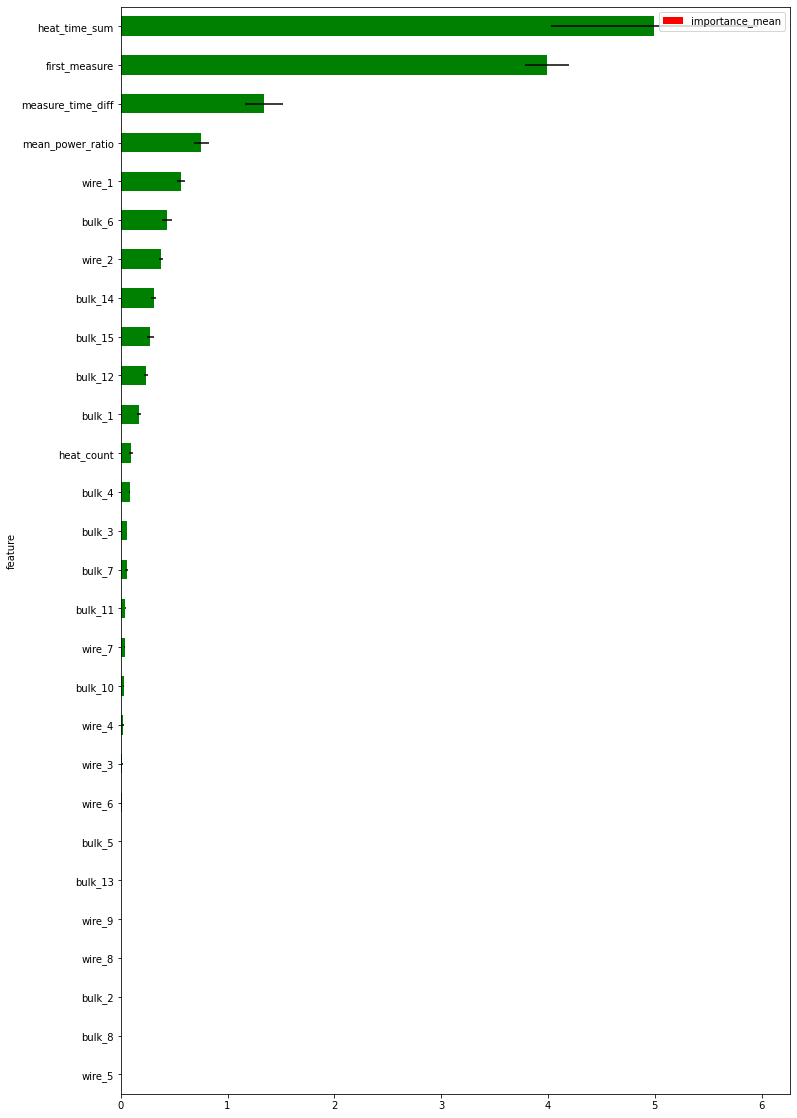

In [74]:
LOFO_train = X_train.copy()
LOFO_train['last_measure'] = y_train
LOFO_train.head()

lofo_imp = FLOFOImportance(cbr, LOFO_train, ['first_measure', 'measure_time_diff', 'heat_count', 'heat_time_sum',
       'mean_power_ratio', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
       'bulk_6', 'bulk_7', 'bulk_8', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
       'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'], 'last_measure', scoring="neg_mean_absolute_error")
importances = lofo_imp.get_importance()
plot_importance(importances, figsize=(12,20))   

Исходя из построенной диаграммы можем увидеть, что признаки добавок, которые, как мы выяснили на этапе EDA, имели малое количество непустых значений, оказывают наименьшее влияние на работу модели. <br>
Ключевыми показателями можно считать суммарное время нагрева, температуру при первом измерении, разницу во времени измерения и среднее соотношение активной и реактивной мощностей.

<a href='#start'>К содержанию</a>

<a id='step5'></a>
# 5. Выводы по работе

В рамках работы был проведен исследовательский анализ данных, показавший особенности имеющихся датасетов. <br>
Был определен подход для составления финального датасета, используемого для обучения моделей, подготовлены отсуствовавшие ранее признаки.

Лучший показатель MAE на тестовой выборке - *5.97*, достигнут с использованием модели `CatBoostRegressor`. Стоит отметить так же и `LGBMRegressor`, метрика которой на тестовом наборе оказалась равна *6.16*.

Помимо этого для лучшей модели осуществлен анализ важности признаков, позволивший определить ключевые параметры.

<a href='#start'>К содержанию</a>